# Comparison: Approach 1 vs DDP Threads

This notebook compares two training approaches:
- **Approach 1**: Sequential training on each split independently (no aggregation)
- **DDP Threads**: Federated learning with model aggregation between communication rounds

Both approaches use the same data splits and starting point for fair comparison.


In [1]:
# Imports
import time
import math
import pickle
import threading
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

%matplotlib inline
print("✓ Imports complete")


✓ Imports complete


## Model Definition


In [2]:
class CollabFiltering(nn.Module):
    def __init__(self, n_users, n_movies, emb_dim=16, hidden=16, dropout=0.1):
        super().__init__()
        self.user_emb = nn.Embedding(n_users, emb_dim)
        self.movie_emb = nn.Embedding(n_movies, emb_dim)
        self.mlp = nn.Sequential(
            nn.Linear(emb_dim * 2, hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, 1),
            nn.ReLU()
        )
    
    def forward(self, u_idx, m_idx):
        u = F.dropout(self.user_emb(u_idx), p=0.4, training=self.training)
        m = F.dropout(self.movie_emb(m_idx), p=0.4, training=self.training)
        return self.mlp(torch.cat([u, m], dim=1)).squeeze()

print("✓ Model class defined")


✓ Model class defined


## Helper Functions


In [3]:
# Custom Adam optimizer (from Approach 1)
def custom_adam(parameters, m_state, v_state, t, lr=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8):
    """Custom Adam optimizer implementation"""
    for p in parameters:
        if p.grad is None:
            continue
        
        if p not in m_state:
            m_state[p] = torch.zeros_like(p)
            v_state[p] = torch.zeros_like(p)
        
        g = p.grad
        m_state[p] = beta1 * m_state[p] + (1 - beta1) * g
        v_state[p] = beta2 * v_state[p] + (1 - beta2) * (g * g)
        
        m_corrected = m_state[p] / (1 - beta1 ** t)
        v_corrected = v_state[p] / (1 - beta2 ** t)
        
        p.data -= lr * m_corrected / (torch.sqrt(v_corrected) + epsilon)
    
    return m_state, v_state

# Weighted average for DDP aggregation
def weighted_average_state_dicts(state_dicts, weights):
    """Weighted average of state dicts based on test losses"""
    total_weight = sum(weights)
    if total_weight == 0:
        weights = [1.0 / len(weights)] * len(weights)
    else:
        weights = [w / total_weight for w in weights]
    
    avg = {}
    for k in state_dicts[0].keys():
        stacked = torch.stack([sd[k].cpu() for sd in state_dicts], dim=0)
        avg[k] = sum(w * stacked[i] for i, w in enumerate(weights))
    return avg

print("✓ Helper functions defined")


✓ Helper functions defined


## Configuration


In [4]:
# Configuration - Modify these as needed
class Config:
    num_workers = 5
    local_epochs = 10
    comm_rounds = 3
    batch_size = 64
    lr = 1e-3
    emb_dim = 16
    hidden = 16
    dropout = 0.1
    seed = 42
    log_every = 2
    agg_timeout = 30.0
    splits_file = "splits.pt"
    save_results = "comparison_results.pkl"

cfg = Config()
total_epochs = cfg.comm_rounds * cfg.local_epochs

print(f"Configuration:")
print(f"  Workers: {cfg.num_workers}")
print(f"  Communication Rounds: {cfg.comm_rounds}")
print(f"  Local Epochs per Round: {cfg.local_epochs}")
print(f"  Total Epochs: {total_epochs}")
print(f"  Batch Size: {cfg.batch_size}")
print(f"  Learning Rate: {cfg.lr}")
print(f"  Seed: {cfg.seed}")


Configuration:
  Workers: 5
  Communication Rounds: 3
  Local Epochs per Round: 10
  Total Epochs: 30
  Batch Size: 64
  Learning Rate: 0.001
  Seed: 42


## Load Data Splits


In [5]:
# Load data splits
tensors_list = torch.load(cfg.splits_file, weights_only=False)
if not isinstance(tensors_list, list) or len(tensors_list) == 0:
    raise RuntimeError(f"{cfg.splits_file} not found or invalid.")

num_workers = min(cfg.num_workers, len(tensors_list))
print(f"✓ Loaded {len(tensors_list)} splits, using {num_workers} workers")

# Calculate global dimensions
global_n_users = max(
    max(int(t["X_train"][:, 0].max().item()), int(t["X_test"][:, 0].max().item()))
    for t in tensors_list
) + 1
global_n_movies = max(
    max(int(t["X_train"][:, 1].max().item()), int(t["X_test"][:, 1].max().item()))
    for t in tensors_list
) + 1

print(f"✓ Global dimensions: {global_n_users} users, {global_n_movies} movies")


✓ Loaded 5 splits, using 5 workers
✓ Global dimensions: 1000 users, 11459 movies


## Approach 1: Sequential Training (No Aggregation)


In [6]:
# Approach 1: Sequential training on each split independently
print("="*60)
print("APPROACH 1: Sequential Training (No Aggregation)")
print("="*60)

approach1_results = []
loss_fn = nn.MSELoss()

for worker_id, tensors_dict in enumerate(tensors_list[:num_workers]):
    print(f"\n--- Training Worker {worker_id} on Split {worker_id} ---")
    torch.manual_seed(cfg.seed + worker_id)
    
    X_train, y_train = tensors_dict["X_train"], tensors_dict["y_train"].float()
    X_test, y_test = tensors_dict["X_test"], tensors_dict["y_test"].float()
    
    model = CollabFiltering(global_n_users, global_n_movies, cfg.emb_dim, cfg.hidden, cfg.dropout)
    m_state, v_state, t = {}, {}, 0
    
    tr_loader = DataLoader(
        TensorDataset(X_train[:, 0].long(), X_train[:, 1].long(), y_train),
        batch_size=cfg.batch_size,
        shuffle=True,
        num_workers=0
    )
    te_loader = DataLoader(
        TensorDataset(X_test[:, 0].long(), X_test[:, 1].long(), y_test),
        batch_size=cfg.batch_size,
        shuffle=False,
        num_workers=0
    )
    
    train_losses = []
    test_losses = []
    train_rmses = []
    test_rmses = []
    
    for epoch in range(total_epochs):
        # Training
        model.train()
        losses = []
        total_sq_error = 0
        total_samples = 0
        
        for u, m, y in tr_loader:
            model.zero_grad()
            preds = model(u, m)
            if preds.dim() == 0:
                preds = preds.unsqueeze(0)
            y = y.view_as(preds)
            loss = loss_fn(preds, y)
            loss.backward()
            t += 1
            m_state, v_state = custom_adam(model.parameters(), m_state, v_state, t, lr=cfg.lr)
            losses.append(loss.item())
            total_sq_error += torch.sum((preds - y) ** 2).item()
            total_samples += len(y)
        
        train_loss = sum(losses) / len(losses) if losses else 0.0
        train_rmse = math.sqrt(total_sq_error / total_samples) if total_samples > 0 else 0.0
        
        # Validation
        model.eval()
        losses = []
        total_sq_error = 0
        total_samples = 0
        
        with torch.no_grad():
            for u, m, y in te_loader:
                preds = model(u, m)
                if preds.dim() == 0:
                    preds = preds.unsqueeze(0)
                y = y.view_as(preds)
                losses.append(loss_fn(preds, y).item())
                total_sq_error += torch.sum((preds - y) ** 2).item()
                total_samples += len(y)
        
        test_loss = sum(losses) / len(losses) if losses else 0.0
        test_rmse = math.sqrt(total_sq_error / total_samples) if total_samples > 0 else 0.0
        
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_rmses.append(train_rmse)
        test_rmses.append(test_rmse)
        
        if (epoch + 1) % cfg.log_every == 0:
            print(
                f"[A1-W{worker_id}] Epoch {epoch+1}/{total_epochs} "
                f"train_loss={train_loss:.4f} train_rmse={train_rmse:.4f} "
                f"test_loss={test_loss:.4f} test_rmse={test_rmse:.4f}"
            )
    
    approach1_results.append({
        "node": worker_id,
        "epoch_states": None,
        "train_losses": train_losses,
        "test_losses": test_losses,
        "train_rmses": train_rmses,
        "test_rmses": test_rmses,
    })

print(f"\n✓ Approach 1 completed: {len(approach1_results)} workers trained")


APPROACH 1: Sequential Training (No Aggregation)

--- Training Worker 0 on Split 0 ---
[A1-W0] Epoch 2/30 train_loss=0.0735 train_rmse=0.2715 test_loss=0.0638 test_rmse=0.2522
[A1-W0] Epoch 4/30 train_loss=0.0590 train_rmse=0.2432 test_loss=0.0566 test_rmse=0.2373
[A1-W0] Epoch 6/30 train_loss=0.0558 train_rmse=0.2366 test_loss=0.0550 test_rmse=0.2339
[A1-W0] Epoch 8/30 train_loss=0.0547 train_rmse=0.2342 test_loss=0.0536 test_rmse=0.2306
[A1-W0] Epoch 10/30 train_loss=0.0531 train_rmse=0.2305 test_loss=0.0512 test_rmse=0.2253
[A1-W0] Epoch 12/30 train_loss=0.0517 train_rmse=0.2276 test_loss=0.0510 test_rmse=0.2248
[A1-W0] Epoch 14/30 train_loss=0.0507 train_rmse=0.2255 test_loss=0.0493 test_rmse=0.2210
[A1-W0] Epoch 16/30 train_loss=0.0495 train_rmse=0.2223 test_loss=0.0479 test_rmse=0.2175
[A1-W0] Epoch 18/30 train_loss=0.0480 train_rmse=0.2194 test_loss=0.0477 test_rmse=0.2171
[A1-W0] Epoch 20/30 train_loss=0.0470 train_rmse=0.2170 test_loss=0.0479 test_rmse=0.2177
[A1-W0] Epoch 22/

In [7]:
# DDP Threads worker function
def worker_proc(worker_id, tensors_dict, shared, shared_lock, global_n_users, global_n_movies):
    torch.manual_seed(cfg.seed + worker_id)

    X_train, y_train = tensors_dict["X_train"], tensors_dict["y_train"].float()
    X_test, y_test = tensors_dict["X_test"], tensors_dict["y_test"].float()
    
    model = CollabFiltering(global_n_users, global_n_movies, cfg.emb_dim, cfg.hidden, cfg.dropout)
    optimizer = torch.optim.Adam(model.parameters(), lr=cfg.lr)
    loss_fn = nn.MSELoss()
    
    tr_loader = DataLoader(
        TensorDataset(X_train[:, 0].long(), X_train[:, 1].long(), y_train),
        batch_size=cfg.batch_size,
        shuffle=True,
        num_workers=0
    )
    te_loader = DataLoader(
        TensorDataset(X_test[:, 0].long(), X_test[:, 1].long(), y_test),
        batch_size=cfg.batch_size,
        shuffle=False,
        num_workers=0
    )
    
    # Load global state if available
    with shared_lock:
        global_state = shared.get("global_state", None)
    if global_state is not None:
        try:
            model.load_state_dict(global_state)
            optimizer = torch.optim.Adam(model.parameters(), lr=cfg.lr)
        except Exception as e:
            print(f"[DDP-W{worker_id}] failed to load initial global_state: {e}")
    
    history = []
    
    for round_idx in range(cfg.comm_rounds):
        best_rmse, best_test_loss, best_state = math.inf, math.inf, None
        
        for epoch in range(cfg.local_epochs):
            # Training
            model.train()
            losses = []
            for u, m, y in tr_loader:
                optimizer.zero_grad()
                preds = model(u, m)
                if preds.dim() == 0:
                    preds = preds.unsqueeze(0)
                y = y.view_as(preds)
                loss = loss_fn(preds, y)
                loss.backward()
                optimizer.step()
                losses.append(loss.item())
            
            train_loss = sum(losses) / len(losses) if losses else 0.0
            train_rmse = math.sqrt(train_loss) if train_loss >= 0 else float("nan")
            
            # Validation
            model.eval()
            losses = []
            with torch.no_grad():
                for u, m, y in te_loader:
                    preds = model(u, m)
                    if preds.dim() == 0:
                        preds = preds.unsqueeze(0)
                    y = y.view_as(preds)
                    losses.append(loss_fn(preds, y).item())
            test_loss = sum(losses) / len(losses) if losses else 0.0
            test_rmse = math.sqrt(test_loss) if test_loss >= 0 else float("nan")
            
            history.append({
                "round": round_idx,
                "epoch_in_round": epoch,
                "global_epoch": round_idx * cfg.local_epochs + epoch,
                "train_loss": train_loss,
                "train_rmse": train_rmse,
                "test_loss": test_loss,
                "test_rmse": test_rmse
            })
            
            if test_rmse < best_rmse:
                best_rmse = test_rmse
                best_test_loss = test_loss
                best_state = {k: v.clone().cpu() for k, v in model.state_dict().items()}
            
            if (epoch + 1) % cfg.log_every == 0:
                print(
                    f"[DDP-W{worker_id}] R{round_idx} E{epoch+1}/{cfg.local_epochs} "
                    f"train_loss={train_loss:.4f} train_rmse={train_rmse:.4f} "
                    f"test_loss={test_loss:.4f} test_rmse={test_rmse:.4f}"
                )
        
        # Signal this worker's best for this round
        with shared_lock:
            shared[f"w{worker_id}_r{round_idx}_best"] = best_state
            shared[f"w{worker_id}_r{round_idx}_rmse"] = best_rmse
            shared[f"w{worker_id}_r{round_idx}_test_loss"] = best_test_loss
            shared[f"w{worker_id}_r{round_idx}_ready"] = True
        
        # Wait for aggregated model
        agg_key = f"agg_r{round_idx}_state"
        waited = 0.0
        while waited <= cfg.agg_timeout:
            with shared_lock:
                agg_state = shared.get(agg_key, None)
            if agg_state is not None:
                try:
                    model.load_state_dict(agg_state)
                    optimizer = torch.optim.Adam(model.parameters(), lr=cfg.lr)
                    print(f"[DDP-W{worker_id}] loaded aggregated model for round {round_idx}")
                except Exception as e:
                    print(f"[DDP-W{worker_id}] failed to load agg: {e}")
                break
            time.sleep(0.2)
            waited += 0.2
        else:
            print(f"[DDP-W{worker_id}] waited {cfg.agg_timeout}s for agg; continuing without it")
    
    with shared_lock:
        shared[f"w{worker_id}_final"] = history
        shared[f"w{worker_id}_done"] = True
    print(f"[DDP-W{worker_id}] finished all rounds")

# Aggregator function
def aggregator(num_workers, shared, shared_lock):
    for r in range(cfg.comm_rounds):
        print(f"[AGG] waiting for {num_workers} workers ready for round {r}...")
        
        while True:
            with shared_lock:
                ready_count = sum(
                    1 for w in range(num_workers)
                    if shared.get(f"w{w}_r{r}_ready", False)
                )
            if ready_count >= num_workers:
                break
            time.sleep(0.2)
        
        with shared_lock:
            states = [shared[f"w{w}_r{r}_best"] for w in range(num_workers)]
            test_losses = [shared[f"w{w}_r{r}_test_loss"] for w in range(num_workers)]
            rmses = [shared[f"w{w}_r{r}_rmse"] for w in range(num_workers)]
        
        weights = [1.0 / (tl + 1e-8) for tl in test_losses]
        agg_state = weighted_average_state_dicts(states, weights)
        
        with shared_lock:
            shared[f"agg_r{r}_state"] = agg_state
        
        print(
            f"[AGG] published aggregated state for round {r} (weighted by test loss), "
            f"worker test_losses={test_losses}, rmses={rmses}"
        )
        
        with shared_lock:
            for w in range(num_workers):
                rk = f"w{w}_r{r}_ready"
                if rk in shared:
                    del shared[rk]
    
    print("[AGG] Waiting for all workers to finish...")
    while True:
        with shared_lock:
            done_count = sum(
                1 for w in range(num_workers)
                if shared.get(f"w{w}_done", False)
            )
        if done_count >= num_workers:
            break
        time.sleep(0.2)
    
    print("[AGG] Collecting worker histories...")
    all_candidates = []
    with shared_lock:
        for w in range(num_workers):
            history = shared.get(f"w{w}_final", [])
            print(f"[AGG] Worker {w} history length: {len(history)}")
            if history:
                all_candidates.append({
                    "node": w,
                    "epoch_states": None,
                    "train_losses": [e["train_loss"] for e in history],
                    "test_losses": [e["test_loss"] for e in history],
                    "train_rmses": [e["train_rmse"] for e in history],
                    "test_rmses": [e["test_rmse"] for e in history],
                })
            else:
                print(f"[AGG] WARNING: Worker {w} has no history!")
        
        shared["all_candidates_stage1"] = all_candidates
        shared["agg_done"] = True
    
    print(f"[AGG] Collected histories from {len(all_candidates)} workers")
    return all_candidates

print("✓ DDP Threads functions defined")


✓ DDP Threads functions defined


In [8]:
# Run DDP Threads
print("="*60)
print("DDP THREADS: Federated Learning (With Aggregation)")
print("="*60)

shared = {}
shared["global_state"] = None
shared["agg_done"] = False
shared_lock = threading.Lock()

# Spawn worker threads
threads = [
    threading.Thread(
        target=worker_proc,
        args=(w, tensors_list[w], shared, shared_lock, global_n_users, global_n_movies),
        daemon=False,
    )
    for w in range(num_workers)
]

for t in threads:
    t.start()

# Aggregator runs in a separate thread
agg_thread = threading.Thread(
    target=aggregator,
    args=(num_workers, shared, shared_lock),
    daemon=False
)
agg_thread.start()

# Wait for aggregator to finish
agg_thread.join()

# Wait for all worker threads to finish
for t in threads:
    t.join()

# Get results
with shared_lock:
    ddp_results = shared.get("all_candidates_stage1", [])

print(f"\n✓ DDP Threads completed: {len(ddp_results)} workers trained")


DDP THREADS: Federated Learning (With Aggregation)
[AGG] waiting for 5 workers ready for round 0...
[DDP-W3] R0 E2/10 train_loss=0.0763 train_rmse=0.2763 test_loss=0.0658 test_rmse=0.2566
[DDP-W1] R0 E2/10 train_loss=0.0644 train_rmse=0.2538 test_loss=0.0588 test_rmse=0.2425
[DDP-W4] R0 E2/10 train_loss=0.0782 train_rmse=0.2797 test_loss=0.0676 test_rmse=0.2600
[DDP-W2] R0 E2/10 train_loss=0.0740 train_rmse=0.2720 test_loss=0.0638 test_rmse=0.2527
[DDP-W0] R0 E2/10 train_loss=0.0744 train_rmse=0.2728 test_loss=0.0623 test_rmse=0.2496
[DDP-W3] R0 E4/10 train_loss=0.0609 train_rmse=0.2467 test_loss=0.0594 test_rmse=0.2437
[DDP-W1] R0 E4/10 train_loss=0.0570 train_rmse=0.2388 test_loss=0.0544 test_rmse=0.2332
[DDP-W4] R0 E4/10 train_loss=0.0609 train_rmse=0.2468 test_loss=0.0582 test_rmse=0.2413
[DDP-W2] R0 E4/10 train_loss=0.0591 train_rmse=0.2431 test_loss=0.0568 test_rmse=0.2384
[DDP-W0] R0 E4/10 train_loss=0.0593 train_rmse=0.2435 test_loss=0.0566 test_rmse=0.2379
[DDP-W3] R0 E6/10 tr

## Save Results


In [9]:
# Helper functions to compute aggregated metrics
def get_avg_curve(results, key):
    avg_curve = []
    for e in range(total_epochs):
        values = []
        for w in results:
            if key in w and isinstance(w[key], list) and e < len(w[key]):
                val = w[key][e]
                if not (isinstance(val, float) and (val != val or np.isinf(val))):
                    values.append(val)
        avg_curve.append(np.mean(values) if values else float("nan"))
    return avg_curve

def get_min_curve(results, key):
    min_curve = []
    for e in range(total_epochs):
        values = []
        for w in results:
            if key in w and isinstance(w[key], list) and e < len(w[key]):
                val = w[key][e]
                if not (isinstance(val, float) and (val != val or np.isinf(val))):
                    values.append(val)
        min_curve.append(min(values) if values else float("nan"))
    return min_curve

def get_max_curve(results, key):
    max_curve = []
    for e in range(total_epochs):
        values = []
        for w in results:
            if key in w and isinstance(w[key], list) and e < len(w[key]):
                val = w[key][e]
                if not (isinstance(val, float) and (val != val or np.isinf(val))):
                    values.append(val)
        max_curve.append(max(values) if values else float("nan"))
    return max_curve

# Compute all aggregated curves
a1_avg_train_loss = get_avg_curve(approach1_results, "train_losses")
a1_avg_test_loss = get_avg_curve(approach1_results, "test_losses")
a1_avg_train_rmse = get_avg_curve(approach1_results, "train_rmses")
a1_avg_test_rmse = get_avg_curve(approach1_results, "test_rmses")
a1_min_train_loss = get_min_curve(approach1_results, "train_losses")
a1_max_train_loss = get_max_curve(approach1_results, "train_losses")
a1_min_test_loss = get_min_curve(approach1_results, "test_losses")
a1_max_test_loss = get_max_curve(approach1_results, "test_losses")

ddp_avg_train_loss = get_avg_curve(ddp_results, "train_losses")
ddp_avg_test_loss = get_avg_curve(ddp_results, "test_losses")
ddp_avg_train_rmse = get_avg_curve(ddp_results, "train_rmses")
ddp_avg_test_rmse = get_avg_curve(ddp_results, "test_rmses")
ddp_min_train_loss = get_min_curve(ddp_results, "train_losses")
ddp_max_train_loss = get_max_curve(ddp_results, "train_losses")
ddp_min_test_loss = get_min_curve(ddp_results, "test_losses")
ddp_max_test_loss = get_max_curve(ddp_results, "test_losses")

# Save comprehensive results
results = {
    "approach1": {
        "all_candidates": approach1_results,
        "aggregated": {
            "avg_train_loss": a1_avg_train_loss,
            "avg_test_loss": a1_avg_test_loss,
            "avg_train_rmse": a1_avg_train_rmse,
            "avg_test_rmse": a1_avg_test_rmse,
            "min_train_loss": a1_min_train_loss,
            "max_train_loss": a1_max_train_loss,
            "min_test_loss": a1_min_test_loss,
            "max_test_loss": a1_max_test_loss,
        },
        "statistics": {
            "final_train_loss": a1_avg_train_loss[-1] if len(a1_avg_train_loss) > 0 else None,
            "final_test_loss": a1_avg_test_loss[-1] if len(a1_avg_test_loss) > 0 else None,
            "final_train_rmse": a1_avg_train_rmse[-1] if len(a1_avg_train_rmse) > 0 else None,
            "final_test_rmse": a1_avg_test_rmse[-1] if len(a1_avg_test_rmse) > 0 else None,
            "best_test_loss": min(a1_avg_test_loss) if len(a1_avg_test_loss) > 0 else None,
            "best_test_loss_epoch": a1_avg_test_loss.index(min(a1_avg_test_loss)) + 1 if len(a1_avg_test_loss) > 0 else None,
            "best_test_rmse": min(a1_avg_test_rmse) if len(a1_avg_test_rmse) > 0 else None,
            "best_test_rmse_epoch": a1_avg_test_rmse.index(min(a1_avg_test_rmse)) + 1 if len(a1_avg_test_rmse) > 0 else None,
        }
    },
    "ddp_threads": {
        "all_candidates": ddp_results,
        "aggregated": {
            "avg_train_loss": ddp_avg_train_loss,
            "avg_test_loss": ddp_avg_test_loss,
            "avg_train_rmse": ddp_avg_train_rmse,
            "avg_test_rmse": ddp_avg_test_rmse,
            "min_train_loss": ddp_min_train_loss,
            "max_train_loss": ddp_max_train_loss,
            "min_test_loss": ddp_min_test_loss,
            "max_test_loss": ddp_max_test_loss,
        },
        "statistics": {
            "final_train_loss": ddp_avg_train_loss[-1] if len(ddp_avg_train_loss) > 0 else None,
            "final_test_loss": ddp_avg_test_loss[-1] if len(ddp_avg_test_loss) > 0 else None,
            "final_train_rmse": ddp_avg_train_rmse[-1] if len(ddp_avg_train_rmse) > 0 else None,
            "final_test_rmse": ddp_avg_test_rmse[-1] if len(ddp_avg_test_rmse) > 0 else None,
            "best_test_loss": min(ddp_avg_test_loss) if len(ddp_avg_test_loss) > 0 else None,
            "best_test_loss_epoch": ddp_avg_test_loss.index(min(ddp_avg_test_loss)) + 1 if len(ddp_avg_test_loss) > 0 else None,
            "best_test_rmse": min(ddp_avg_test_rmse) if len(ddp_avg_test_rmse) > 0 else None,
            "best_test_rmse_epoch": ddp_avg_test_rmse.index(min(ddp_avg_test_rmse)) + 1 if len(ddp_avg_test_rmse) > 0 else None,
        }
    },
    "config": {
        "comm_rounds": cfg.comm_rounds,
        "local_epochs": cfg.local_epochs,
        "total_epochs": total_epochs,
        "num_workers": num_workers,
        "batch_size": cfg.batch_size,
        "lr": cfg.lr,
        "emb_dim": cfg.emb_dim,
        "hidden": cfg.hidden,
        "dropout": cfg.dropout,
        "seed": cfg.seed,
        "global_n_users": global_n_users,
        "global_n_movies": global_n_movies,
    },
    "metadata": {
        "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
    }
}

with open(cfg.save_results, "wb") as f:
    pickle.dump(results, f)

print(f"✓ Results saved to {cfg.save_results}")
print(f"  - Individual worker data: {len(approach1_results)} workers for each approach")
print(f"  - Aggregated curves: Average, Min, Max for all metrics")
print(f"  - Statistics: Final and best values for all metrics")


✓ Results saved to comparison_results.pkl
  - Individual worker data: 5 workers for each approach
  - Aggregated curves: Average, Min, Max for all metrics
  - Statistics: Final and best values for all metrics


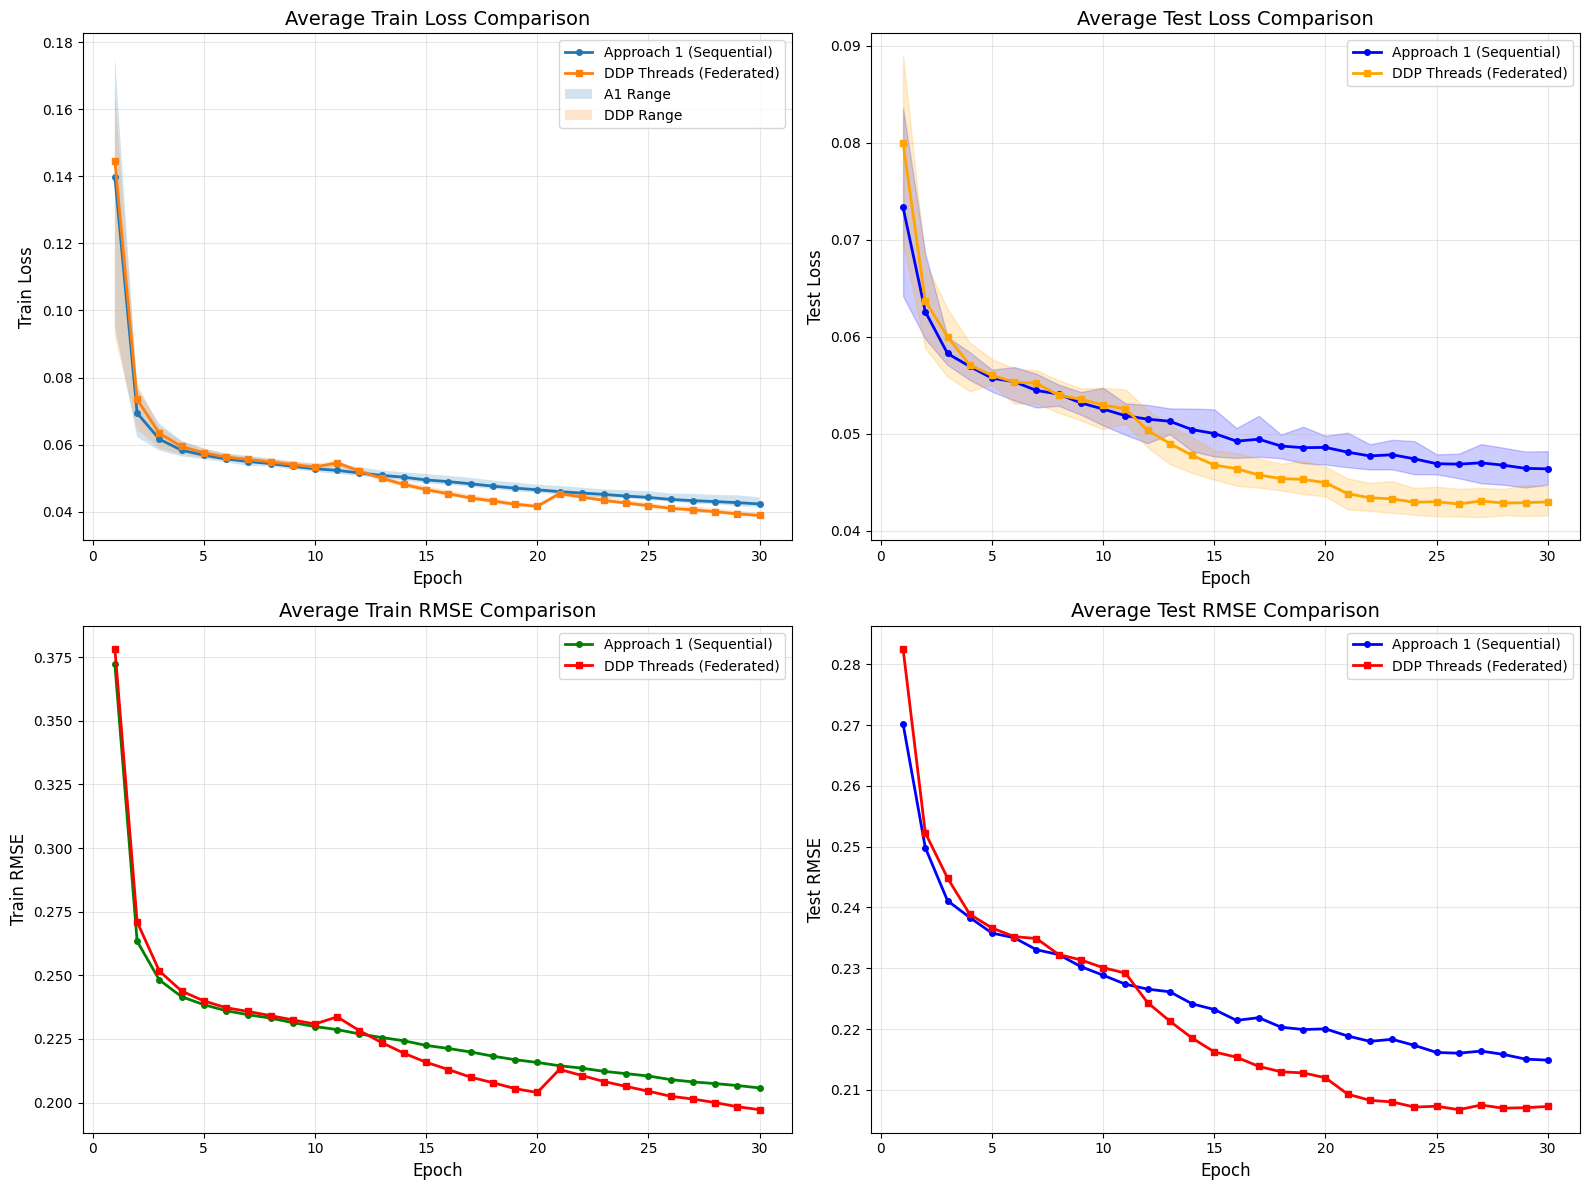

In [ ]:
# Basic comparison plot - 4 subplots
x = range(1, total_epochs + 1)

fig = plt.figure(figsize=(16, 12))

# Plot 1: Train Loss
ax1 = plt.subplot(2, 2, 1)
ax1.plot(x, a1_avg_train_loss, marker="o", label="Approach 1 (Sequential)", linewidth=2, markersize=4)
ax1.plot(x, ddp_avg_train_loss, marker="s", label="DDP Threads (Federated)", linewidth=2, markersize=4)
ax1.set_xlabel("Epoch", fontsize=12)
ax1.set_ylabel("Train Loss", fontsize=12)
ax1.set_title("Average Train Loss Comparison", fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=10)

# Plot 2: Test Loss
ax2 = plt.subplot(2, 2, 2)
ax2.plot(x, a1_avg_test_loss, marker="o", label="Approach 1 (Sequential)", linewidth=2, markersize=4, color="blue")
ax2.plot(x, ddp_avg_test_loss, marker="s", label="DDP Threads (Federated)", linewidth=2, markersize=4, color="orange")
ax2.fill_between(x, a1_min_test_loss, a1_max_test_loss, alpha=0.2, color="blue")
ax2.fill_between(x, ddp_min_test_loss, ddp_max_test_loss, alpha=0.2, color="orange")
ax2.set_xlabel("Epoch", fontsize=12)
ax2.set_ylabel("Test Loss", fontsize=12)
ax2.set_title("Average Test Loss Comparison", fontsize=14)
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=10)

# Plot 3: Train RMSE
ax3 = plt.subplot(2, 2, 3)
ax3.plot(x, a1_avg_train_rmse, marker="o", label="Approach 1 (Sequential)", linewidth=2, markersize=4, color="green")
ax3.plot(x, ddp_avg_train_rmse, marker="s", label="DDP Threads (Federated)", linewidth=2, markersize=4, color="red")
ax3.set_xlabel("Epoch", fontsize=12)
ax3.set_ylabel("Train RMSE", fontsize=12)
ax3.set_title("Average Train RMSE Comparison", fontsize=14)
ax3.grid(True, alpha=0.3)
ax3.legend(fontsize=10)

# Plot 4: Test RMSE
ax4 = plt.subplot(2, 2, 4)
ax4.plot(x, a1_avg_test_rmse, marker="o", label="Approach 1 (Sequential)", linewidth=2, markersize=4, color="blue")
ax4.plot(x, ddp_avg_test_rmse, marker="s", label="DDP Threads (Federated)", linewidth=2, markersize=4, color="red")
ax4.set_xlabel("Epoch", fontsize=12)
ax4.set_ylabel("Test RMSE", fontsize=12)
ax4.set_title("Average Test RMSE Comparison", fontsize=14)
ax4.grid(True, alpha=0.3)
ax4.legend(fontsize=10)

plt.tight_layout()
plt.show()


## Plot 2: Individual Worker Performance


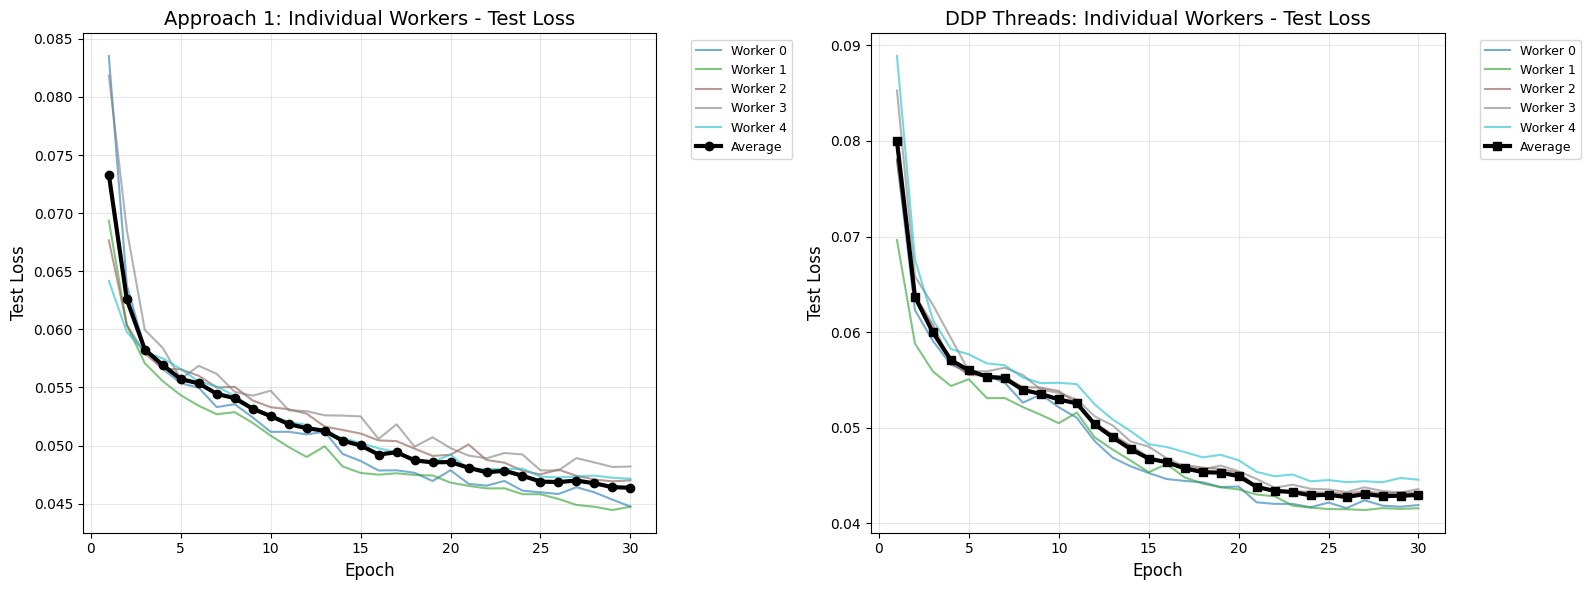

In [11]:
# Individual worker performance for both approaches
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

colors = plt.cm.tab10(np.linspace(0, 1, num_workers))

# Approach 1 workers
for i, worker in enumerate(approach1_results):
    ax1.plot(x[:len(worker["test_losses"])], worker["test_losses"], 
            label=f"Worker {i}", alpha=0.6, linewidth=1.5, color=colors[i])

ax1.plot(x, a1_avg_test_loss, marker="o", label="Average", linewidth=3, markersize=6, color="black")
ax1.set_xlabel("Epoch", fontsize=12)
ax1.set_ylabel("Test Loss", fontsize=12)
ax1.set_title("Approach 1: Individual Workers - Test Loss", fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)

# DDP Threads workers
for i, worker in enumerate(ddp_results):
    ax2.plot(x[:len(worker["test_losses"])], worker["test_losses"], 
            label=f"Worker {i}", alpha=0.6, linewidth=1.5, color=colors[i])

ax2.plot(x, ddp_avg_test_loss, marker="s", label="Average", linewidth=3, markersize=6, color="black")
ax2.set_xlabel("Epoch", fontsize=12)
ax2.set_ylabel("Test Loss", fontsize=12)
ax2.set_title("DDP Threads: Individual Workers - Test Loss", fontsize=14)
ax2.grid(True, alpha=0.3)
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)

plt.tight_layout()
plt.show()


## Plot 3: Side-by-Side Train vs Test


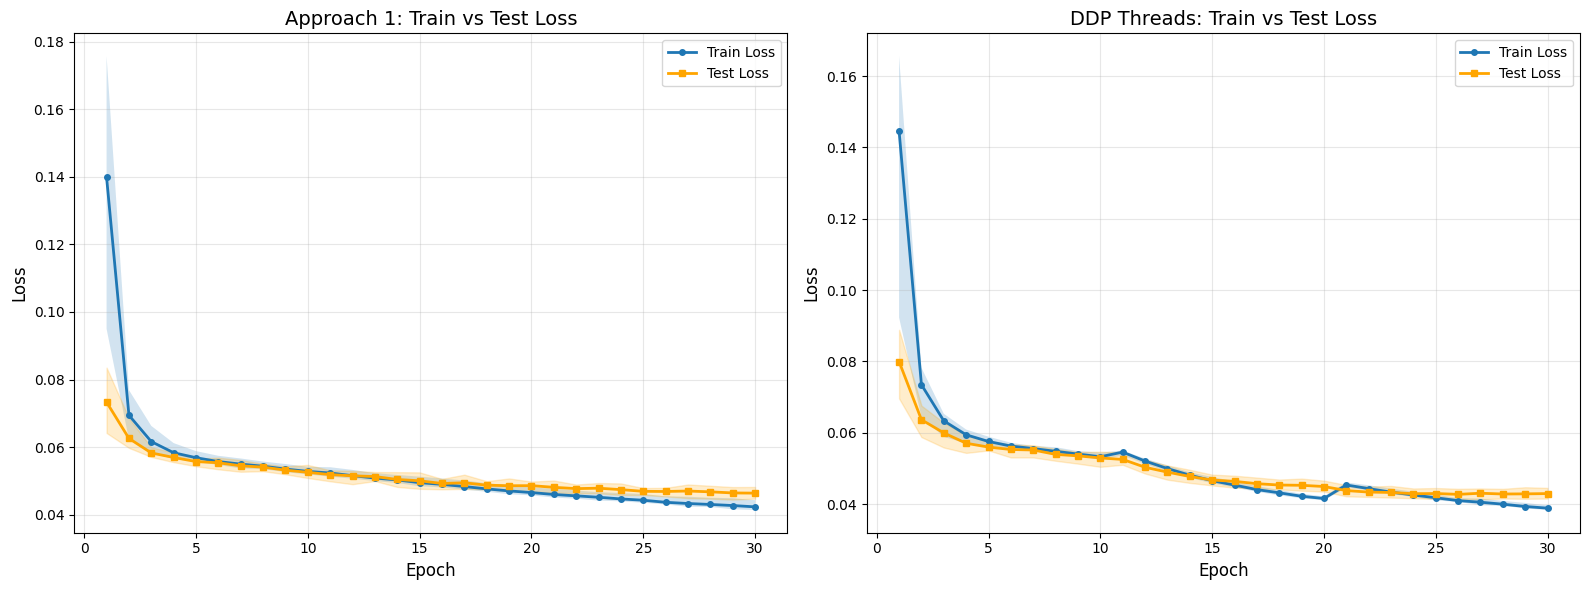

In [12]:
# Side-by-side comparison of train vs test
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Approach 1
ax1 = axes[0]
ax1.plot(x, a1_avg_train_loss, marker="o", label="Train Loss", linewidth=2, markersize=4)
ax1.plot(x, a1_avg_test_loss, marker="s", label="Test Loss", linewidth=2, markersize=4, color="orange")
ax1.fill_between(x, a1_min_train_loss, a1_max_train_loss, alpha=0.2)
ax1.fill_between(x, a1_min_test_loss, a1_max_test_loss, alpha=0.2, color="orange")
ax1.set_xlabel("Epoch", fontsize=12)
ax1.set_ylabel("Loss", fontsize=12)
ax1.set_title("Approach 1: Train vs Test Loss", fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=10)

# DDP Threads
ax2 = axes[1]
ax2.plot(x, ddp_avg_train_loss, marker="o", label="Train Loss", linewidth=2, markersize=4)
ax2.plot(x, ddp_avg_test_loss, marker="s", label="Test Loss", linewidth=2, markersize=4, color="orange")
ax2.fill_between(x, ddp_min_train_loss, ddp_max_train_loss, alpha=0.2)
ax2.fill_between(x, ddp_min_test_loss, ddp_max_test_loss, alpha=0.2, color="orange")
ax2.set_xlabel("Epoch", fontsize=12)
ax2.set_ylabel("Loss", fontsize=12)
ax2.set_title("DDP Threads: Train vs Test Loss", fontsize=14)
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=10)

plt.tight_layout()
plt.show()


## Summary Statistics


In [13]:
# Print summary statistics
print("="*60)
print("SUMMARY STATISTICS")
print("="*60)

a1_stats = results["approach1"]["statistics"]
ddp_stats = results["ddp_threads"]["statistics"]

print(f"\nConfiguration:")
print(f"  Workers: {num_workers}")
print(f"  Total Epochs: {total_epochs} ({cfg.comm_rounds} rounds × {cfg.local_epochs} epochs)")
print(f"  Learning Rate: {cfg.lr}")
print(f"  Batch Size: {cfg.batch_size}")

print(f"\nApproach 1 (Sequential Training):")
print(f"  Final Train Loss: {a1_stats['final_train_loss']:.4f}")
print(f"  Final Test Loss: {a1_stats['final_test_loss']:.4f}")
print(f"  Final Train RMSE: {a1_stats['final_train_rmse']:.4f}")
print(f"  Final Test RMSE: {a1_stats['final_test_rmse']:.4f}")
print(f"  Best Test Loss: {a1_stats['best_test_loss']:.4f} (Epoch {a1_stats['best_test_loss_epoch']})")
print(f"  Best Test RMSE: {a1_stats['best_test_rmse']:.4f} (Epoch {a1_stats['best_test_rmse_epoch']})")

print(f"\nDDP Threads (Federated Learning):")
print(f"  Final Train Loss: {ddp_stats['final_train_loss']:.4f}")
print(f"  Final Test Loss: {ddp_stats['final_test_loss']:.4f}")
print(f"  Final Train RMSE: {ddp_stats['final_train_rmse']:.4f}")
print(f"  Final Test RMSE: {ddp_stats['final_test_rmse']:.4f}")
print(f"  Best Test Loss: {ddp_stats['best_test_loss']:.4f} (Epoch {ddp_stats['best_test_loss_epoch']})")
print(f"  Best Test RMSE: {ddp_stats['best_test_rmse']:.4f} (Epoch {ddp_stats['best_test_rmse_epoch']})")

print(f"\nComparison:")
print(f"  Test Loss Difference: {abs(a1_stats['final_test_loss'] - ddp_stats['final_test_loss']):.4f}")
print(f"  Test RMSE Difference: {abs(a1_stats['final_test_rmse'] - ddp_stats['final_test_rmse']):.4f}")
print("="*60)


SUMMARY STATISTICS

Configuration:
  Workers: 5
  Total Epochs: 30 (3 rounds × 10 epochs)
  Learning Rate: 0.001
  Batch Size: 64

Approach 1 (Sequential Training):
  Final Train Loss: 0.0423
  Final Test Loss: 0.0464
  Final Train RMSE: 0.2057
  Final Test RMSE: 0.2149
  Best Test Loss: 0.0464 (Epoch 30)
  Best Test RMSE: 0.2149 (Epoch 30)

DDP Threads (Federated Learning):
  Final Train Loss: 0.0389
  Final Test Loss: 0.0430
  Final Train RMSE: 0.1972
  Final Test RMSE: 0.2073
  Best Test Loss: 0.0427 (Epoch 26)
  Best Test RMSE: 0.2067 (Epoch 26)

Comparison:
  Test Loss Difference: 0.0034
  Test RMSE Difference: 0.0076
